<a href="https://colab.research.google.com/github/PotoyanGroup/Seq2Ensemble/blob/main/ColabOpenAWSEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup the software

In [1]:
#@title Run this cell to set working environment
!pip install -q condacolab
import condacolab
condacolab.install()

import warnings
warnings.filterwarnings("ignore")

✨🍰✨ Everything looks OK!


In [30]:
#@title Run this cell to install required software (OpenMM, OpenAWSEM, Stride, BLAST ...)
%%capture
%%shell
#1. Install OpenMM and core dependencies
conda install -c conda-forge openmm pdbfixer mdtraj biopython nglview  numpy pandas matplotlib
pip install --upgrade MDAnalysis

#2. Download openawsem
git clone https://github.com/PotoyanGroup/openawsem

#3. Download pdb_seqres
wget ftp://ftp.wwpdb.org/pub/pdb/derived_data/pdb_seqres.txt
mv pdb_seqres.txt openawsem/

#4. Download and isntall stride
wget http://webclu.bio.wzw.tum.de/stride/stride.tar.gz
mkdir stride_loc && tar -xf stride.tar.gz -C ./stride_loc
cd stride_loc && make


#5. Download and isntall BLAST (needed only for multi-fragment simulations)
#wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/LATEST/ncbi-blast-2.13.0+-src.tar.gz
#mkdir blast_loc && tar  -xf ncbi-blast-2.13.0+-src.tar.gz
#cd ncbi-blast-2.13.0+-src.tar.gz && ./configure
#cd ncbi-blast-2.13.0+-src.tar.gz && make


### Create Project and Run simulation

Upload a PDB file of protein which can be obtained either via AlphaFold or from PDB database. 

In [3]:
#@title Upload a PDB file
from google.colab import files
import os

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  os.rename(fn, 'input.pdb')

# Create project 

Saving 5kb5.pdb to 5kb5.pdb
User uploaded file "5kb5.pdb" with length 520587 bytes


In [13]:
#@title Run a constant temperature Molecular Dynamics sampling with [AWSEM](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008308) coarse-grained force-field for proteins 
Temperature = 250.0 #@param {type:"number"}
Timesteps   = 100000 #@param {type:"number"}

!export PATH={$PATH}:/content/stride_loc && python3 /content/openawsem/mm_create_project.py input.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 ./openawsem/helperFunctions/convertOpenmmTrajectoryToStandardMovie.py input-openmmawsem.pdb
!export OPENAWSEM_LOCATION=/content/openawsem/ && python3 mm_run.py input  --steps $Timesteps --tempStart $Temperature --tempEnd $Temperature -f forces_setup.py


#@markdown ---
#@markdown > Lu, Wei, et al. "OpenAWSEM with Open3SPN2: A fast, flexible, and accessible framework for large-scale coarse-grained biomolecular simulations." <em>PLoS computational biology 17.2 (2021): e1008308 </em>

Chains info read from crystal_structure.pdb, chains to simulate:  A
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5337
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5337
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5337
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5337
  PDBConstructionWarning,
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: Ignoring unrecognized record 'END' at line 5337
  PDBConstructionWarning,
protein: input, length: 341
/usr/local/lib/python3.7/site-packages/Bio/PDB/PDBParser.py:399: PDBConstructionWarning: 

## Visualize the data

In [46]:
#@markdown ## Run this  cell to load libraries for visualization and plots

#@markdown #### May need to close the pop up window and re-run the cell for animation to work

import mdtraj as md
import nglview as nv
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import output
output.enable_custom_widget_manager()

def viz_q_e(file='info.dat'):

  data = pd.read_csv(file, sep='\s+')

  fig, ax = plt.subplots(ncols=3)

  ax[2].plot(data['Steps'], data['Rg'])
  ax[2].set_ylabel('Rg')
  ax[2].set_xlabel('Time Steps')

  ax[1].plot(data['Steps'], data['Q'])
  ax[1].set_ylabel('Fraction of native contacts')
  ax[1].set_xlabel('Time Steps')

  ax[0].plot(data['Steps'], data['Total'], color='red')
  ax[0].set_ylabel('Energy, kj/mol')
  ax[0].set_xlabel('Time Steps')
  fig.tight_layout()


def viz_traj(file='movie.dcd', topo='input-openmmawsem.pdb'):

  traj = md.load(file, top=topo)
  view = nv.show_mdtraj(traj)
  return view

viz_traj()

NGLWidget(max_frame=117)

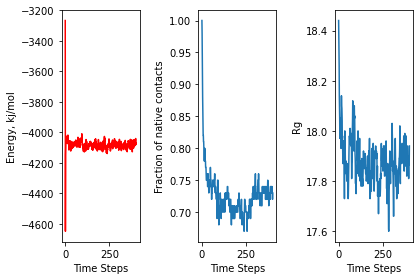

In [47]:
#@markdown Plot timeseries of observables of interest.
viz_q_e()

## Clustering


In [34]:
from Bio.PDB import PDBParser
import MDAnalysis.analysis.encore as encore
import MDAnalysis as mda

#@title Choose number of clusters to generate
#@title Number fields
n_clusters = 10 #@param {type:"number"}


pdb   = 'input-openmmawsem.pdb'
model = PDBParser().get_structure('structure',pdb)

# hold chain IDs and residue object lists
# use to compare the subunits and figure out if they're identical or not
chains = {}
for chain in model.get_chains():
  chains[chain.id] = chain.get_unpacked_list()

trajectory = 'movie.dcd'
structure = 'input-openmmawsem.pdb'
u = mda.Universe(structure, trajectory)

#############################

# make a dictionary of chain/subunit keys with atom selection values
selections = {}
for chain in chains.keys():
  selections[chain] = u.select_atoms('segid '+chain)

# make a directory to hold the seperated subunits
out_dir = 'seperated_trajectories/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
# clean the directory if it already exists
for f in os.listdir(out_dir):
    os.remove(out_dir+f)

# Instead of writing the seperated trajectories to files, 
# can probably use u.merge()
for chain, selection in selections.items():
    with mda.Writer(out_dir+'chain_'+chain+'.dcd', selection.n_atoms) as W:
        for ts in u.trajectory:
            W.write(selection)
# write one subunit to a pdb
# can probably just use the selection instead of a saved pdb
# assuming we're just working with EI dimer for this
selections[list(selections.keys())[0]].write('one_subunit.pdb')
# align
from MDAnalysis.analysis import align
seperated_trajs = [out_dir+traj for traj in os.listdir(out_dir) if traj.endswith('dcd')]
new_pdb = 'one_subunit.pdb'
ref = mda.Universe(new_pdb)
sep_u = mda.Universe(new_pdb, seperated_trajs)
align.AlignTraj(sep_u, ref,select='name CA',filename='aligned_seperated_subunits.dcd').run()

for cluster_iteration in range(n_clusters):
    structure = 'one_subunit.pdb'
    trajectory = 'aligned_seperated_subunits.dcd'
    u = mda.Universe(structure, trajectory)
    # add n_jobs argument so that all n_init are run in parallel (default is 10)
    ensemble = encore.cluster(u, method=encore.clustering.ClusteringMethod.KMeans(n_clusters=cluster_iteration+1))
    #####################################
    # change this selection from 'name CA' to 'protein' when using structure file with 
    # correct residue names
    #####################################
    selection = u.select_atoms('protein')
    ######################################
    clusters = []
    for i, cluster in enumerate(ensemble.clusters):
        u.trajectory[cluster.centroid]
        if not os.path.exists(f'cluster_{cluster_iteration+1}/'):
          os.makedirs(f'cluster_{cluster_iteration+1}/')
        selection.write(f'cluster_{cluster_iteration+1}/centroid_{i+1}.pdb')
        clusters.append(int(cluster.centroid))